## Mini syrinx model 

For the dual pathway model, we would like to test it using a syrinx-based performance contour.
For this, we attempt to generate a performance landscape using a syrinx model used by Darshan, Amador, etc.
https://doi.org/10.1038/nature11967

Here, we provide two vectors, pressure and tension, as input.
The model comprises two ODEs, which produces the labial position x(t) and velocity y(t).

We transform this to generate song, and see the frequency distribution.

From this frequency distribution, we build the performance landscape.

In [72]:
#Libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import queue
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
from scipy.interpolate import interp2d
import warnings
from tqdm import tqdm

In [73]:
np.random.seed(100)

In [74]:
# Parameters
gamma = 12000 
duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4
Amp = 4
nt = int(duration/dt)

# Trachea parameters
r = -0.9
v = 350*100
L = 1.9
tau_0 = 2*L/v # Propagation time along trachea
tau_n = int(tau_0/dt)

In [75]:
syllable = 1

In [76]:
# RC4
# syllable 1
if syllable == 1:
    def Tension(t, T_beta):
        """ Generalised exponential waveform """
        return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) + T_beta
        
    def Pressure(t, P_alpha):
        """ Constant """
        return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05 + P_alpha  
# RC5 - test
elif syllable == 2:
    # syllable 2
    def Tension(t, T_beta):
        """ Generalised exponential waveform """
        Tc = 1#2/3
        return   .3 - .2*np.exp(-Tc*3*100*t) -.00001 * np.exp(Tc*3*100*t) + T_beta  

    def Pressure(t, P_alpha):
        """ Constant """
        tp = 0.2
        return tp*np.sin((duration/2 + t)*np.pi*10) + 0.05 + P_alpha    
elif syllable == 3:
    # syllable 3
    def Tension(t, T_beta): 
        """
            Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
            Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
        """
        scale = 1
        if isinstance(t, float):
            if t <= duration*scale/2: 
                return 5*np.sin(t*np.pi*40/scale) + 0.6 + T_beta# old amp 0.1 
            elif t <= duration*scale: 
                return 10*np.sin((t-duration*scale/2)*np.pi*15/scale) + 0.6 + T_beta# old amp 0.2
            else: 
                return 0.0 + 0*t
        elif isinstance(t, np.ndarray):
            Tension1 = 5*np.sin(t*np.pi*40/scale) + 0.6 + T_beta # old amp 0.1
            Tension2 = 10*np.sin(t*np.pi*15/scale) + 0.6 + T_beta # old amp 0.2
            Tension3 = 0.0 + 0*t
            return np.concatenate((Tension1[:int(np.ceil(t.size*scale/2))], Tension2[:int(t.size*scale-t.size*scale/2)], Tension3[:int(t.size-t.size*scale)]))        
    
    def Pressure(t, P_alpha):
        """ Pressure = 0.02 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 2 + P_alpha # old amp 0.16

elif syllable == 4:
    # syllable 4
    def Tension(t, T_beta):
        scale = 0.4
        if isinstance(t, float):
            if t <= duration*scale: 
                return 0.8*np.sin(t*np.pi*20/scale) + 0.6 + T_beta# old amp 0.1
            else: 
                return t*0 + 0.6 + T_beta# old amp 0.2
        elif isinstance(t, np.ndarray):
            Tension1 = 0.8*np.sin(t*np.pi*20/scale) + 0.6 + T_beta# old amp 0.1
            Tension2 = t* 0 + 0.6 + T_beta# old amp 0.2
            return np.concatenate((Tension1[:int(np.ceil(t.size*scale))], Tension2[:int(t.size-t.size*scale)]))
          
    def Pressure(t, P_alpha):
        """ Pressure = 0.02 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.01 + P_alpha  
        
elif syllable == 5:
    # syllable 5
    def Tension(t, T_beta):
        """ Tension = 0.2 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.2 + T_beta
        
    def Pressure(t):
        """ Pressure = 0.1 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.1 + P_alpha 
elif syllable == 6:
    # syllable 6
    def Tension(t, T_beta):
        """
            Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
            Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
        """
        if isinstance(t, float):
            if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6 + T_beta
            else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6 + T_beta
        elif isinstance(t, np.ndarray):
            Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6 + T_beta
            Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6 + T_beta
            return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
        
    def Pressure(t):
        """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
        return 0.01*np.sin(t*np.pi*2*100) + 0.02 + P_alpha 


In [77]:
def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    global P_alpha, T_beta
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t, P_alpha)*(gamma**2) - Tension(t, T_beta)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]

    return dydt

# def Syrinx(P_alpha, T_beta):
#     ''' Simulating a syrinx using pressure and tension inputs. '''
#     solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)
#     # Extract labial position (X) and velocity (Y)
#     X = solution['y'][0]
#     Y = solution['y'][1]
#     time_x = np.linspace(0, duration, nt)
#     song = Amp * Pressure(time_x, P_alpha) * Y
#     return song

def Syrinx(P_alpha, T_beta): # faster function
    """
    Simulating a syrinx using pressure and tension inputs.

    Args:
        P_alpha: Pressure parameter.
        T_beta: Tension parameter.

    Returns:
        The simulated song.
    """
    # Pre-compute constants outside the loop for efficiency
    if not hasattr(Syrinx, 'Amp'):  # Check if Amp is already defined
        Syrinx.Amp = Amp  # Avoid redundant calculations
    time_x = np.linspace(0, duration, nt)
    # Vectorize pressure calculation (assuming Pressure is vectorized)
    pressure = Pressure(time_x, P_alpha)
    solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method="RK45", t_eval=time_x)
    X = solution['y'][0]
    Y = solution['y'][1]
    song = Syrinx.Amp * pressure * Y
    return song

def Trachea(song):
    """ Simulating the progression of pressure through a trachea. """
    
    y0 = song.T

    # To generate pressure output from trachea
    P_i=np.zeros((len(y0)))

    # See Fig 1 in Amador paper. Round-about way to implement that.
    Buffer = queue.Queue()
    for i in np.arange(tau_n):
        Buffer.put(np.random.random())

    for i in np.arange(len(y0)):
        P_i[i] = y0[i] - r*Buffer.get();      
        # update_buffer
        Buffer.put(P_i[i])

    # P_tr from P_in (ref Amador paper)
    BufferB=np.zeros((tau_n))
    P_tmp= np.concatenate((BufferB, P_i))
    P_t=(1-r)*P_tmp[:-tau_n]
    return P_t


In [78]:
def plot_gradient(ax, Z, figure):
    """ Plots reward contour. """
    contour = ax.contourf(Z, 25, extent=[0.0, 1.0, 0.0, 0.2], cmap="gray_r", alpha=.25)
#     cbar = figure.colorbar(contour)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.5)
    cbar = figure.colorbar(contour, cax=cax)
    cbar.set_label('Performance metric (R)', rotation=270, fontsize=20, labelpad=25)
    
def create_template(P_alpha=0.02, T_beta=0.6):
    """ Creates spectrogram template from target song. """
    song = Syrinx(P_alpha, T_beta)
    P_tr = Trachea(song)
    (freqs, t, spectrum) = spectrogram(P_tr, fs=1/dt)
    target_spectrum = spectrum

    templateSpec = target_spectrum
    mts = np.mean(templateSpec)
    templateSpec = templateSpec - mts
    templateLen = np.sqrt(np.sum(templateSpec ** 2))
    templateSpec = templateSpec / templateLen
    
    return templateSpec

def compute_corr_coeff(currentSpec, templateSpec):
    """ Computes correlation coefficient. """
    m = np.mean(currentSpec)
    currentSpec = currentSpec - m
    currentLen = np.sqrt(np.sum(currentSpec ** 2))
    currentSpec = currentSpec / currentLen
    
    return np.mean(currentSpec.T@templateSpec)
    


In [79]:
def generate_gradient(templateSpec, P_init, T_init, deltas, n=256): # function for any initial p and t values
    """ Generates the reward contour by simulating the song for each input combination
        and storing the similarity metric w.r.t. the target song. """
    global P_alpha, T_beta
    delta_P = deltas[syllable - 1][0]
    delta_T = deltas[syllable - 1][1]
    P_range = np.linspace(P_init - delta_P, P_init + delta_P, n)
    T_range = np.linspace(T_init - delta_T, T_init + delta_T, n)
    Spectrums = np.zeros((n, n, 129, 9)) # Hardcoded in a hurry
    # Spectrums = np.load('Figures/spectrums_n'+str(n)+'.npy')
    Z = np.zeros((n,n))
    for i, P_alpha in tqdm(enumerate(P_range)):
        for j, T_beta in enumerate(T_range):    
            song = Syrinx(P_alpha, T_beta)
            P_tr = Trachea(song)
            (freqs, t, spectrum) = spectrogram(P_tr, fs=1/dt)
            Spectrums[i, j] = spectrum
#             spectrum = Spectrums[i, j]
            Z[i, j] = compute_corr_coeff(spectrum, templateSpec)
#     np.save('Figures/spectrums_n'+str(n), Spectrums)
    return Z

# def generate_gradient(templateSpec, n=256): # old function
#     """ Generates the reward contour by simulating the song for each input combination
#         and storing the similarity metric w.r.t. the target song. """
#     Spectrums = np.zeros((n, n, 129, 9)) # Hardcoded in a hurry
#     # Spectrums = np.load('Figures/spectrums_n'+str(n)+'.npy')
#     Z = np.zeros((n,n))
#     for i in tqdm(np.arange(n)):
#         for j in np.arange(n):
#             P_alpha = i/n*0.2 #+ 0.0
#             T_beta = j/n*1. #+ 0.0
#             song = Syrinx(P_alpha, T_beta)
#             P_tr = Trachea(song)
#             (freqs, t, spectrum) = spectrogram(P_tr, fs=1/dt)
#             Spectrums[i, j] = spectrum
# #             spectrum = Spectrums[i, j]
#             Z[i, j] = compute_corr_coeff(spectrum, templateSpec)
# #     np.save('Figures/spectrums_n'+str(n), Spectrums)
#     return Z

In [80]:
# Assign target song
# P_init = 0.05 # y axis
# T_init = 0.3 # y axis

init_vals = [[0.05, 0.3], # syllable 1
             [0.05, 0.3], # syllable 2
             [0.05, 0.3], # syllable 3
             [0.00, 0.2]] # syllable 4

P_init = init_vals[syllable - 1][0]
T_init = init_vals[syllable - 1][1]

# devaition for p and t of each syllable
# 2nd value scales inversly in x axis
deltas = [[0.1, 0.5], # syllable 1
          [0.1, 0.5], # syllable 2
          [1, 1], # syllable 3
          [0.1, 0.3]] # syllable 4

P_alpha = P_init
T_beta = T_init 

templateSpec = create_template(P_alpha, T_beta)

In [81]:
# Generate reward contour based on similarity to assigned target song

nZ = 10 # Specify resolution of performance landscape

Z = generate_gradient(templateSpec, P_init, T_init, deltas, nZ)


10it [00:13,  1.34s/it]


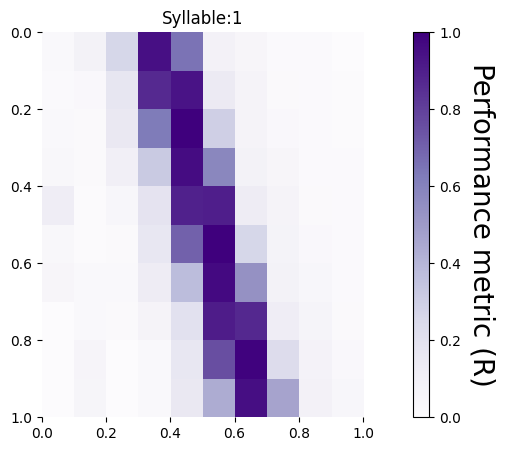

In [82]:
# Normalise and plot contour
# Z = np.load(f'contours/Syll{syllable}.npy')
Z = Z/np.max(Z)
figure = plt.figure(figsize=(5,5))
ax = plt.subplot(frameon=False)

# im = ax.imshow(Z , vmin=0, vmax=Z.max(), cmap='Purples', extent=[0, 0.1, 0, 0.02], aspect='auto')
im = ax.imshow(Z , vmin=Z.min(), vmax=Z.max(), cmap='Purples', extent=[0, 1, 0, 1], aspect='auto')
ax.invert_yaxis() 

# Display colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
cbar = figure.colorbar(im, cax=cax)
cbar.set_label('Performance metric (R)', rotation=270, fontsize=20, labelpad=25)
ax.set_title(f'Syllable:{syllable}')

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.show()

In [83]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

def make_contour(Z, n=256):
    # Normalize
    Z = Z / Z.max()

    # Transform exponentially
    Z = np.power(1000, Z)
    Z = Z / Z.max()

    # Original grid (careful: Z.shape[0] is rows -> y, Z.shape[1] is cols -> x)
    x = np.linspace(0, 1., Z.shape[1])   # width / columns
    y = np.linspace(0, .2, Z.shape[0])   # height / rows

    # New grid
    x2 = np.linspace(0, 1., n)
    y2 = np.linspace(0, .2, n)

    # Interpolator (cubic splines)
    f = RectBivariateSpline(y, x, Z, kx=3, ky=3)
    Z = f(y2, x2)  # Note: order is (y, x)

    # Normalize again
    Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))
    Z = Z / Z.max()

    # Get target (location of max)
    targetZpos = np.argwhere(Z == 1)[0]  # [row, col] = [y, x]

    targetpos = np.zeros(2)
    targetpos[0] = (targetZpos[1] / Z.shape[1]) * 2 - 1  # x in [-1, 1]
    targetpos[1] = (targetZpos[0] / Z.shape[0]) * 2 - 1  # y in [-1, 1]

    return Z, targetpos


# ---- Test code ----
contour, targetpos = make_contour(Z, 256)

# reward function
def syrinx_landscape(coordinates, n=256):
    x, y = coordinates[0], coordinates[1]
    x = max(min(x, 0.999), -1)
    y = max(min(y, 0.999), -1)
    xi = int((x + 1) / 2 * n)
    yi = int((y + 1) / 2 * n)
    return contour[yi, xi]  # NOTE: rows = y, cols = x

print(f'Target position: {targetpos}')  
print(f'Target reward: {syrinx_landscape([1,1])}')


Target position: [ 0.1015625 -0.140625 ]
Target reward: 0.13196457499506034


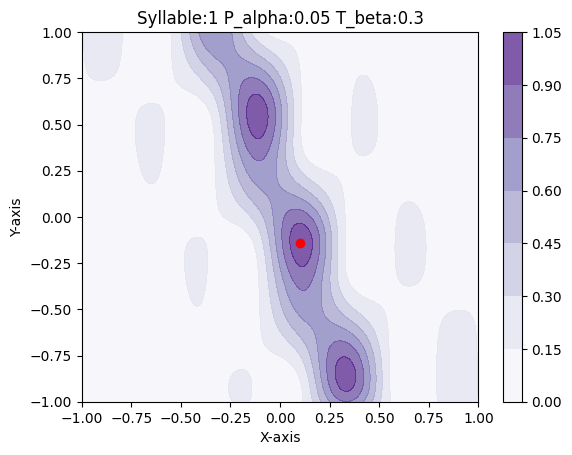

In [84]:

plt.figure()
# Plot the contour lines on top of the imshow
# cs = plt.contour(contour, cmap='Purples', extent=[-1, 1, -1, 1])
# plt.imshow(contour, cmap='Purples', extent=[-1, 1, -1, 1], alpha=0.7)  # Adjust alpha for transparency
# plt.colorbar().
plt.contourf(contour, cmap='Purples', extent=[-1, 1, -1, 1], alpha=0.7)  # Adjust alpha for transparency
plt.colorbar()
plt.scatter(targetpos[0], targetpos[1], c='r', label='Target')
# Title and labels
plt.title(f'Syllable:{syllable} P_alpha:{P_init} T_beta:{T_init}')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [85]:
def find_peaks(array, threshold):
    """
    Finds local maxima (peaks) in a 2D array exceeding a threshold.

    Args:
        array: The 2D array to search for peaks.
        threshold: The minimum value to consider an element a peak.

    Returns:
        A list of tuples representing peak coordinates (row, col).
    """
    peaks = []
    rows, cols = array.shape

    for i in range(rows):
        for j in range(cols):
            # Check for valid comparisons based on array boundaries
            is_peak = True
            if i > 0 and array[i][j] <= array[i-1][j]:
                is_peak = False
            if i < rows-1 and array[i][j] <= array[i+1][j]:
                is_peak = False
            if j > 0 and array[i][j] <= array[i][j-1]:
                is_peak = False
            if j < cols-1 and array[i][j] <= array[i][j+1]:
                is_peak = False

            # Only consider elements exceeding the threshold
            if is_peak and array[i][j] >= threshold:
                peaks.append((i, j))
    return peaks

20
Syllable: 1 peak heights
Peak:1 0.13445651854507917 - [-0.9296875 -0.65625  ]
Peak:2 0.15910331188885232 - [-0.9296875 -0.1953125]
Peak:3 0.132030361286948 - [-0.90625 -1.     ]
Peak:4 0.9816202227482766 - [-0.859375  0.328125]
Peak:5 0.26736301529868595 - [-0.859375   0.8984375]
Peak:6 0.1406659969389544 - [-0.2421875 -0.90625  ]
Peak:7 0.15912517362534176 - [-0.2421875 -0.421875 ]
Peak:8 0.16993863676397283 - [-0.171875  0.640625]
Peak:9 1.0 - [-0.140625   0.1015625]
Peak:10 0.1320495349426977 - [0.0625    0.9921875]
Peak:11 0.13310681006513014 - [ 0.109375 -1.      ]
Peak:12 0.16600945426262603 - [ 0.4609375 -0.6484375]
Peak:13 0.1634945191322884 - [0.5078125 0.4140625]
Peak:14 0.14198252056757318 - [0.5078125 0.8984375]
Peak:15 0.9915486818037421 - [ 0.546875  -0.1171875]
Peak:16 0.13210644942092092 - [ 0.6171875 -1.       ]
Peak:17 0.22709110552896247 - [ 0.9921875 -0.90625  ]
Peak:18 0.734572733104621 - [ 0.9921875 -0.328125 ]
Peak:19 0.14403883015343416 - [0.9921875 0.1875   

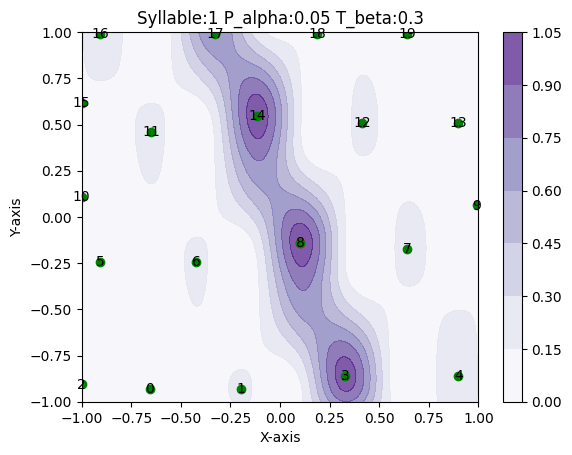

In [93]:
# Recursively find peaks in sub-arrays (excluding center element)
peaks = find_peaks(contour, 0.1)
peaks = np.array(peaks)
print(len(peaks))
# print(f'Peaks: {np.array(peaks) / 128 - 1}')   
print(f"Syllable: {syllable} peak heights")
for i in range(len(peaks)):
    print(f"Peak:{i+1} {contour[peaks[i][0], peaks[i][1]]} - {np.array(peaks[i]) / 128 - 1}")

plt.figure()
plt.contourf(contour, cmap='Purples', extent=[-1, 1, -1, 1], alpha=0.7)  # Adjust alpha for transparency
plt.colorbar()
plt.scatter(targetpos[0], targetpos[1], c='r', label='Target')
plt.scatter([peak[1] / 256 * 2 - 1 for peak in peaks], [peak[0] / 256 * 2 - 1 for peak in peaks], c='g', label='Peaks')
# Title and labels
for i, peak in enumerate(peaks):
    plt.text(peak[1] / 256 * 2 - 1, peak[0] / 256 * 2 - 1, f'{i}', fontsize=10, color='black', ha='center', va='center')
plt.title(f'Syllable:{syllable} P_alpha:{P_init} T_beta:{T_init}')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()



In [87]:
# swap values inside
peak_coordinates = np.array(peaks) / 128 - 1
peak_coordinates = peak_coordinates[:, ::-1]  # Swap x and y coordinates    

In [88]:
P_init, T_init

(0.05, 0.3)

In [89]:
for i in range(len(peak_coordinates)):
    print(f"Coord {i}: {peak_coordinates[i]} | Height: {contour[peaks[i][0], peaks[i][1]]} | Delta: {deltas[syllable]*(targetpos - peak_coordinates[i])}")

Coord 0: [-0.65625   -0.9296875] | Height: 0.13445651854507917 | Delta: [0.07578125 0.39453125]
Coord 1: [-0.1953125 -0.9296875] | Height: 0.15910331188885232 | Delta: [0.0296875  0.39453125]
Coord 2: [-1.      -0.90625] | Height: 0.132030361286948 | Delta: [0.11015625 0.3828125 ]
Coord 3: [ 0.328125 -0.859375] | Height: 0.9816202227482766 | Delta: [-0.02265625  0.359375  ]
Coord 4: [ 0.8984375 -0.859375 ] | Height: 0.26736301529868595 | Delta: [-0.0796875  0.359375 ]
Coord 5: [-0.90625   -0.2421875] | Height: 0.1406659969389544 | Delta: [0.10078125 0.05078125]
Coord 6: [-0.421875  -0.2421875] | Height: 0.15912517362534176 | Delta: [0.05234375 0.05078125]
Coord 7: [ 0.640625 -0.171875] | Height: 0.16993863676397283 | Delta: [-0.05390625  0.015625  ]
Coord 8: [ 0.1015625 -0.140625 ] | Height: 1.0 | Delta: [0. 0.]
Coord 9: [0.9921875 0.0625   ] | Height: 0.1320495349426977 | Delta: [-0.0890625 -0.1015625]
Coord 10: [-1.        0.109375] | Height: 0.13310681006513014 | Delta: [ 0.11015625

In [90]:
print(f"{deltas[syllable]*(targetpos - peak_coordinates)}") #+ (P_init,T_init)

[[ 0.07578125  0.39453125]
 [ 0.0296875   0.39453125]
 [ 0.11015625  0.3828125 ]
 [-0.02265625  0.359375  ]
 [-0.0796875   0.359375  ]
 [ 0.10078125  0.05078125]
 [ 0.05234375  0.05078125]
 [-0.05390625  0.015625  ]
 [ 0.          0.        ]
 [-0.0890625  -0.1015625 ]
 [ 0.11015625 -0.125     ]
 [ 0.075      -0.30078125]
 [-0.03125    -0.32421875]
 [-0.0796875  -0.32421875]
 [ 0.021875   -0.34375   ]
 [ 0.11015625 -0.37890625]
 [ 0.10078125 -0.56640625]
 [ 0.04296875 -0.56640625]
 [-0.00859375 -0.56640625]
 [-0.05390625 -0.56640625]]


In [91]:
peak_coordinates

array([[-0.65625  , -0.9296875],
       [-0.1953125, -0.9296875],
       [-1.       , -0.90625  ],
       [ 0.328125 , -0.859375 ],
       [ 0.8984375, -0.859375 ],
       [-0.90625  , -0.2421875],
       [-0.421875 , -0.2421875],
       [ 0.640625 , -0.171875 ],
       [ 0.1015625, -0.140625 ],
       [ 0.9921875,  0.0625   ],
       [-1.       ,  0.109375 ],
       [-0.6484375,  0.4609375],
       [ 0.4140625,  0.5078125],
       [ 0.8984375,  0.5078125],
       [-0.1171875,  0.546875 ],
       [-1.       ,  0.6171875],
       [-0.90625  ,  0.9921875],
       [-0.328125 ,  0.9921875],
       [ 0.1875   ,  0.9921875],
       [ 0.640625 ,  0.9921875]])

In [92]:
# np.save(f'contours/Syll{syllable}.npy', Z)